In [26]:
# --- Importing the necessary libraries ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [27]:
# --- Data load and Feature Engineering ---
df = pd.read_csv("../data/SPX.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")

# Select the first date where volume data is reliable to start the analysis
first_valid_volume_date = df[df["Volume"] > 0].index[0]
df_model = df.loc[first_valid_volume_date:].copy()

# 1. Log Returns: Measures the proportional return of the asset
df_model["Log_Return"] = np.log(df_model["Close"]/df_model["Close"].shift(1))

# 2. Volatility (Annualized): Standard deviation of returns over a 21-day window (approx. 1 month)
df_model["Volatility"] = df_model["Log_Return"].rolling(window=21).std()*np.sqrt(252) 

# 3. Momentum (126d): Measures the 6-month price change (126 trading days)
df_model["Momentum_126d"] = (df_model["Close"] - df_model["Close"].shift(126))/df_model["Close"].shift(126)

# Drop rows with NaN values created by rolling windows and shifting
df_model.dropna(inplace=True)

In [28]:
# --- Data Scaling (StandardScaler) ---

# Select the features for the HMM Model
features = ['Log_Return', 'Volatility', 'Momentum_126d']
X = df_model[features]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the data and transform it
X_scaled = scaler.fit_transform(X)

# Convert the NumPy array back to a Pandas DataFrame (Good practice for tracking)
df_scaled = pd.DataFrame(X_scaled, columns = features, index = df_model.index)

print(df_scaled.head())

            Log_Return  Volatility  Momentum_126d
Date                                             
1950-07-05    0.935898    1.636076       0.236710
1950-07-06    0.533881    1.570493       0.179775
1950-07-07   -1.388665    1.593439       0.001155
1950-07-10   -0.486997    1.532642      -0.071272
1950-07-11   -1.587839    1.533520      -0.274775


In [29]:
from hmmlearn.hmm import GMMHMM

# Fix the random seed for reproducible results (deterministic regime assignment)
np.random.seed(123)

# --- Architecture Definition ---
K = 3 # Number of regimes (Bull, Bear, Transition)
M = 2 # Number of mixture components (to model Fat Tails)
COVARIANCE = 'full' # Covariance type to capture correlations (Leverage Effect)

# Controlled initialization of the model (init_params='')
model = GMMHMM( 
    n_components = K,
    n_mix = M,
    covariance_type = COVARIANCE, 
    init_params='',
    n_iter = 100,
    tol = 1e-4
)

# Initial probability (Uniform start probability)
model.startprob_ = np.full(K, 1.0 / K)

# Configure transition matrix (Fosters 95% persistence in each regime)
prob_diag = 0.95
prob_off_diag = (1 - prob_diag) / (K - 1)

model.transmat_ = np.full((K, K), 0.0)

for i in range(K):
    model.transmat_[i, i] = prob_diag
    for j in range(K):
        if i!= j:
            model.transmat_[i, j] = prob_off_diag

print("Transition matrix (Initial):\n", model.transmat_)

# Fit the HMM to the scaled data (Expectation-Maximization algorithm)
model.fit(X_scaled)

# Decode the most likely sequence of hidden states (Viterbi algorithm)
regime_labels = model.predict(X_scaled)

# Assign the resulting regime labels back to the main DataFrame
df_model['Regime'] = regime_labels

Transition matrix (Initial):
 [[0.95  0.025 0.025]
 [0.025 0.95  0.025]
 [0.025 0.025 0.95 ]]


In [30]:
# --- Regime Validation and Characterization ---

# Define metrics to analyze the characteristics of each regime
metrics = ['mean', 'std']

# Group the data by the inferred 'Regime' and calculate statistics 
regime_summary = df_model.groupby('Regime')[['Log_Return', 'Volatility', 'Momentum_126d']].agg(metrics)

print(regime_summary)

       Log_Return           Volatility           Momentum_126d          
             mean       std       mean       std          mean       std
Regime                                                                  
0        0.000692  0.006619   0.096385  0.039477      0.133555  0.070436
1       -0.000164  0.016669   0.237507  0.118678     -0.057613  0.112532
2        0.000181  0.007120   0.111654  0.023629      0.014453  0.054469


In [31]:
# ---  Naming the Regimes Deterministically ---

# Based on the printed regime_summary table (from Cell 5) and the fixed seed, 
# we assign meaningful financial names to the numeric labels:

# 0: Bull (Highest Return, Lowest Volatility)
# 1: Bear (Negative Return, Highest Volatility)
# 2: Transicion (Intermediate Metrics)

regime_names = {
    0: 'Bull', 
    1: 'Bear', 
    2: 'Transition'
}

# Apply the mapping to create a new categorical column
df_model['Regime_Name'] = df_model['Regime'].map(regime_names)

print("Regimes have been assigned descriptive names (Bull, Bear, Transicion).")
print(df_model[['Regime', 'Regime_Name']].head())

Regimes have been assigned descriptive names (Bull, Bear, Transicion).
            Regime Regime_Name
Date                          
1950-07-05       1        Bear
1950-07-06       1        Bear
1950-07-07       1        Bear
1950-07-10       1        Bear
1950-07-11       1        Bear


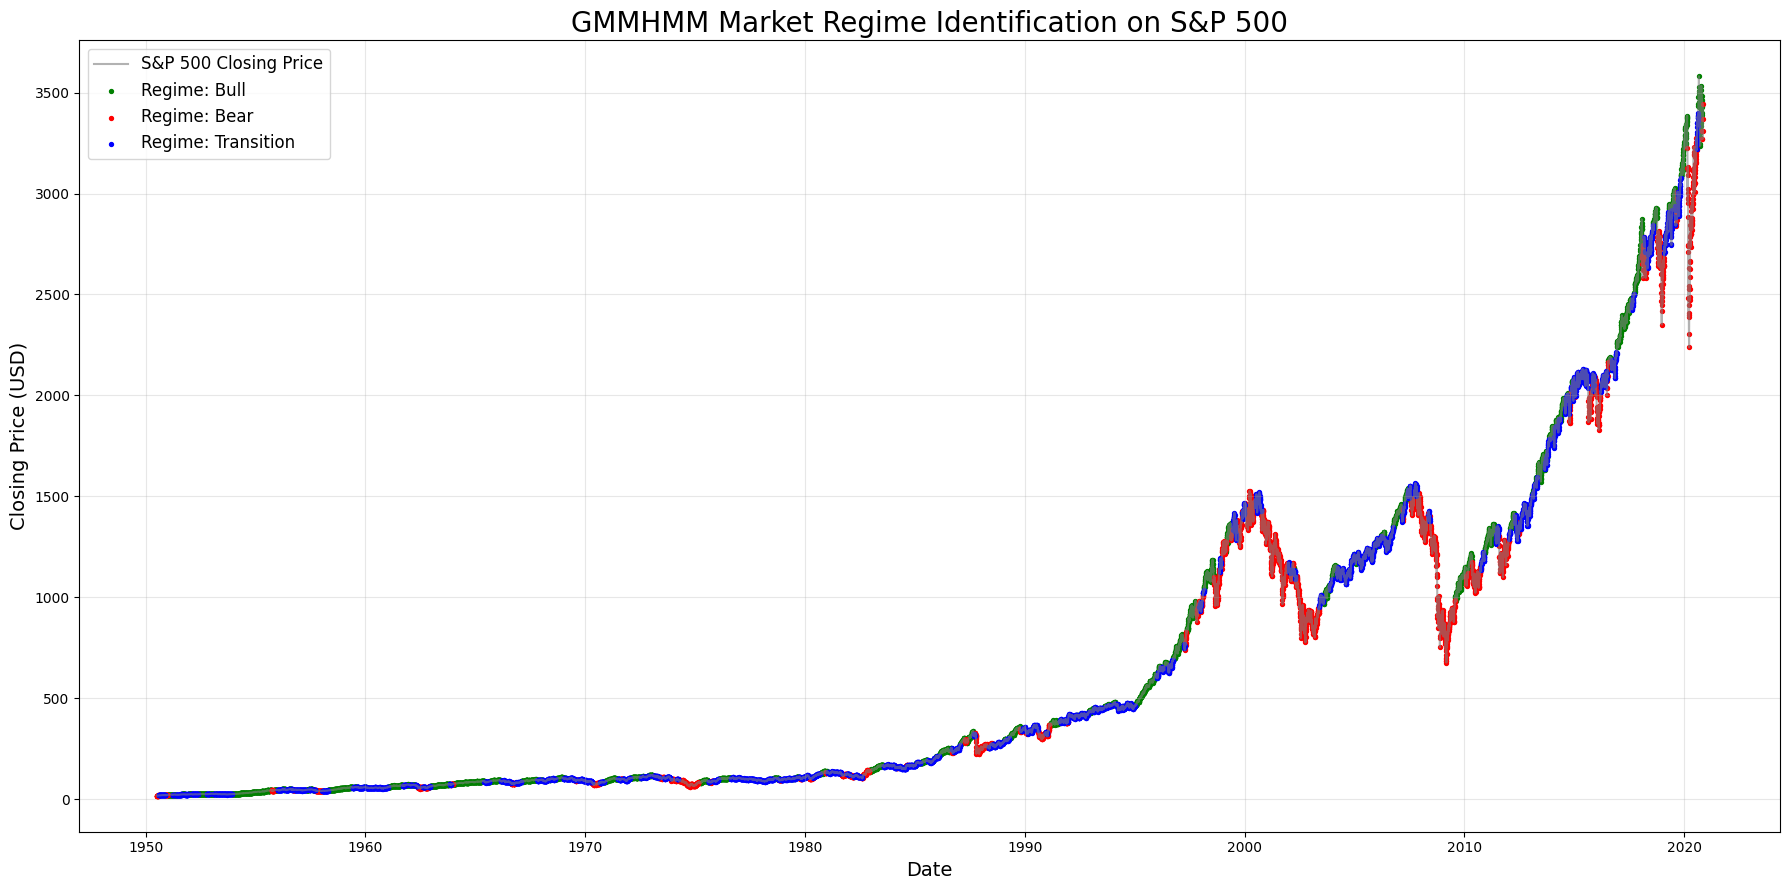

In [32]:
# --- Final Visualization of Market Regimes ---

# 1. Define Color Map
color_map = {
    'Bull': 'green',   
    'Bear': 'red',     
    'Transition': 'blue',
}

# 2. Create a column for plotting colors
df_model['Regime_Color'] = df_model['Regime_Name'].map(color_map)

# 3. Generate Final Visualization 
plt.figure(figsize=(18, 9))

# Plot the closing price as a reference (gray line)
plt.plot(df_model.index, df_model['Close'], color='gray', alpha=0.6, label='S&P 500 Closing Price')

# Superimpose the colored regimes onto the price chart
for name, color in color_map.items():
    subset = df_model[df_model['Regime_Name'] == name]
    plt.scatter(subset.index, subset['Close'], color=color, s=8, label=f'Regime: {name}')

# Final Customization
plt.title('GMMHMM Market Regime Identification on S&P 500', fontsize=20)
plt.ylabel('Closing Price (USD)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()